In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use('ggplot')

In [2]:
def load_nlg_results_dataframe(language: str) -> pd.DataFrame:
    df = (
        pd
        .read_csv(f'https://scandeval.com/{language}-nlg.csv')
        .query('merge == False')
        .set_index('model_id')
    )
    df.index = df.index.map(lambda x: re.sub('\(.*\)', '', x).strip())
    df = df.drop('danish-foundation-models/munin-7b-v0.1dev0', errors='ignore')
    columns_to_keep = [col for col in df.columns if "rank" in col] + ["commercially_licensed"]
    df = df[columns_to_keep]
    return df

In [3]:
language_mapping = {
    'no': ('mainland-scandinavian', 'no_rank', 'Norwegian'),
    'sv': ('mainland-scandinavian', 'sv_rank', 'Swedish'),
    'da': ('mainland-scandinavian', 'da_rank', 'Danish'),
    'is': ('insular-scandinavian', 'is_rank', 'Icelandic'),
    'fo': ('insular-scandinavian', 'fo_rank', 'Faroese'),
    'nl': ('dutch', 'rank', 'Dutch'),
    'de': ('german', 'rank', 'German'),
    'en': ('english', 'rank', 'English'),
}

In [4]:
def get_colour(row: pd.Series) -> str:
    if not row.commercially_licensed:
        return "red"
    if "/" not in row.name or "danskgpt-chat-v2.1" in row.name:
        return "black"
    return "dodgerblue"

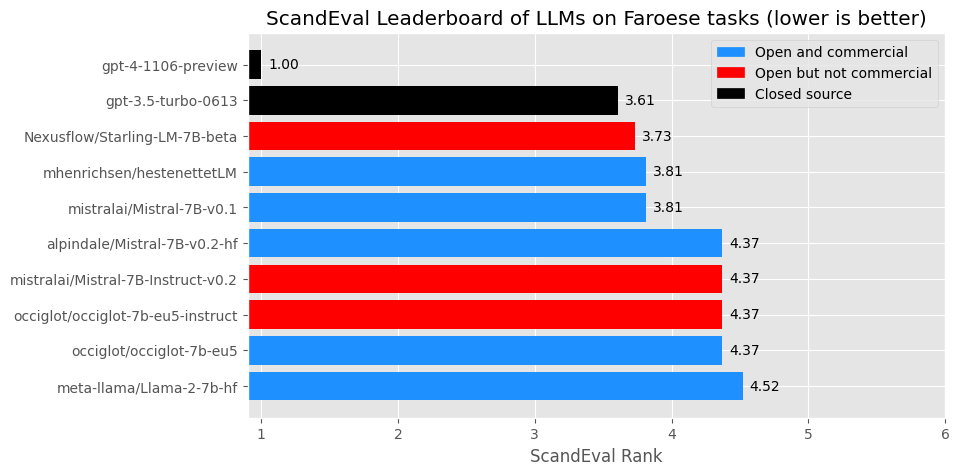

In [12]:
LANGUAGE = 'fo'
TOP_N = 10
MAX_VAL = 6

leaderboard, score_column, title = language_mapping[LANGUAGE]
df = load_nlg_results_dataframe(language=leaderboard)
top_df = df.sort_values(by=score_column).head(TOP_N)[::-1]

colours = [get_colour(row=row) for _, row in top_df.iterrows()]
plt.figure(figsize=(9, 5))
plot = plt.barh(y=top_df.index, width=top_df[score_column], color=colours)
plt.legend(
    handles=[
        mpatches.Patch(color='dodgerblue', label='Open and commercial'),
        mpatches.Patch(color='red', label='Open but not commercial'),
        mpatches.Patch(color='black', label='Closed source'),
    ],
)
plt.title(f'ScandEval Leaderboard of LLMs on {title} tasks (lower is better)')
plt.xticks(range(0, MAX_VAL + 1))
plt.xlim(0.9, MAX_VAL)
plt.xlabel('ScandEval Rank')
plt.bar_label(plot, padding=5, fmt="{:.2f}")
plt.savefig(f'/Users/dan/Downloads/{LANGUAGE}-llm-leaderboard.png', dpi=100, bbox_inches = "tight")
plt.show()